In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os

## Velocity Loss

In [2]:
# Read the geopackage file
path_gpkg = 'outputs/geopackages/ZonalStat_Ecoregions_EWM_v2.gpkg'
if not os.path.exists(path_gpkg):
    raise FileNotFoundError(f"File not found: {path_gpkg}")

# Read the geopackage using geopandas
ecoregions_exp = gpd.read_file(path_gpkg, layer="zonal_statistics")
ecoregions_exp = ecoregions_exp.drop(['fire_count', 'fire_area_ha'], axis=1)
ecoregions_exp.dtypes

OBJECTID                                         float64
ECO_NAME                                          object
BIOME_NUM                                        float64
BIOME_NAME                                        object
REALM                                             object
ECO_BIOME_                                        object
NNH                                                int64
ECO_ID                                             int64
SHAPE_LENG                                       float64
SHAPE_AREA                                       float64
NNH_NAME                                          object
COLOR                                             object
COLOR_BIO                                         object
COLOR_NNH                                         object
LICENSE                                           object
ZonalStat_Ecoregions_EWM_nino_EWMnina_median     float64
ZonalStat_Ecoregions_EWM_nino_EWMnino_median     float64
geometry                       

In [9]:
ecoregions_exp.shape

(179, 24)

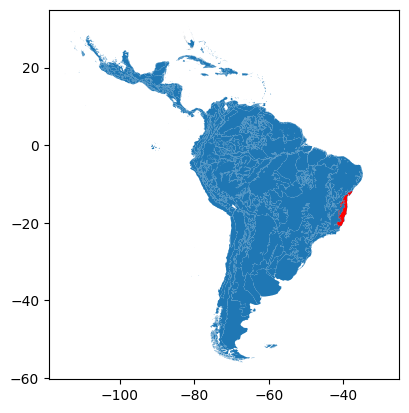

In [3]:
# Plot
fig, ax = plt.subplots()
ecoregions_exp.plot(ax=ax)
ecoregions_exp[ecoregions_exp['ECO_NAME'] == 'Bahia coastal forests'].plot(ax=ax,color='red')
plt.show()


In [4]:
# Read CSV with treecover loss %/year
forest_cover = pd.read_csv('inputs/04_csv/Forest_PrimaryLoss_Per_Year_Stats_50_v2.csv')
forest_cover = forest_cover.drop(['.geo', 'system:index'], axis=1)

forest_cover.dtypes

BIOME_NAME                      object
BIOME_NUM                      float64
COLOR                           object
COLOR_BIO                       object
COLOR_NNH                       object
ECO_BIOME_                      object
ECO_ID                           int64
ECO_NAME                        object
LICENSE                         object
Loss_Per_Year_%                float64
NNH                              int64
NNH_NAME                        object
OBJECTID                       float64
PrimaryForestArea_50           float64
REALM                           object
SHAPE_AREA                     float64
SHAPE_LENG                     float64
Total_PrimaryLoss_2001_2023    float64
dtype: object

In [5]:

# Identify the common column
common_column = 'ECO_NAME'

# Merge the DataFrames based on the common column
# Select only the two additional columns from CSV
additional_columns = [col for col in forest_cover.columns if col not in ecoregions_exp.columns and col != common_column]
# Merge the DataFrame with the GeoDataFrame
ecoregions_exp = ecoregions_exp.merge(forest_cover[[common_column] + additional_columns], on=common_column, how="left")
ecoregions_exp.dtypes


OBJECTID                                         float64
ECO_NAME                                          object
BIOME_NUM                                        float64
BIOME_NAME                                        object
REALM                                             object
ECO_BIOME_                                        object
NNH                                                int64
ECO_ID                                             int64
SHAPE_LENG                                       float64
SHAPE_AREA                                       float64
NNH_NAME                                          object
COLOR                                             object
COLOR_BIO                                         object
COLOR_NNH                                         object
LICENSE                                           object
ZonalStat_Ecoregions_EWM_nino_EWMnina_median     float64
ZonalStat_Ecoregions_EWM_nino_EWMnino_median     float64
geometry                       

## Fires treecover 50

In [6]:
# Read CSV with fires
df_fires_50 = pd.read_csv('inputs/04_csv/PrimaryLoss_by_Fires_Stats_50_v3.csv')
df_fires_50 = df_fires_50.drop(['.geo', 'system:index'], axis=1)
df_fires_50.dtypes

BIOME_NAME                 object
BIOME_NUM                 float64
COLOR                      object
COLOR_BIO                  object
COLOR_NNH                  object
ECO_BIOME_                 object
ECO_ID                      int64
ECO_NAME                   object
LICENSE                    object
Loss_Fires_50%            float64
NNH                         int64
NNH_NAME                   object
OBJECTID                  float64
PrimaryLoss_by_fires50    float64
Primary_loss50            float64
REALM                      object
SHAPE_AREA                float64
SHAPE_LENG                float64
dtype: object

In [7]:
df_fires_50 = df_fires_50.rename(columns={'PrimaryForestArea_50': 'Treecover_loss50', 'Total_PrimaryLoss_2001_2023': 'Loss_by_fires50'})
df_fires_50.dtypes

BIOME_NAME                 object
BIOME_NUM                 float64
COLOR                      object
COLOR_BIO                  object
COLOR_NNH                  object
ECO_BIOME_                 object
ECO_ID                      int64
ECO_NAME                   object
LICENSE                    object
Loss_Fires_50%            float64
NNH                         int64
NNH_NAME                   object
OBJECTID                  float64
PrimaryLoss_by_fires50    float64
Primary_loss50            float64
REALM                      object
SHAPE_AREA                float64
SHAPE_LENG                float64
dtype: object

In [8]:
# Identify the common column
common_column = 'ECO_NAME'

# Merge the DataFrames based on the common column
# Select only the two additional columns from CSV
additional_columns = [col for col in df_fires_50.columns if col not in ecoregions_exp.columns and col != common_column]
# Merge the DataFrame with the GeoDataFrame
ecoregions_exp = ecoregions_exp.merge(df_fires_50[[common_column] + additional_columns], on=common_column, how="left")
ecoregions_exp.dtypes

OBJECTID                                         float64
ECO_NAME                                          object
BIOME_NUM                                        float64
BIOME_NAME                                        object
REALM                                             object
ECO_BIOME_                                        object
NNH                                                int64
ECO_ID                                             int64
SHAPE_LENG                                       float64
SHAPE_AREA                                       float64
NNH_NAME                                          object
COLOR                                             object
COLOR_BIO                                         object
COLOR_NNH                                         object
LICENSE                                           object
ZonalStat_Ecoregions_EWM_nino_EWMnina_median     float64
ZonalStat_Ecoregions_EWM_nino_EWMnino_median     float64
geometry                       

In [9]:
ecoregions_exp['velocity'] = (ecoregions_exp['Primary_loss50']/(ecoregions_exp['PrimaryForestArea_50']*23))*100

In [30]:
# Save the updated GeoDataFrame to a new geopackage
ecoregions_exp.to_file('outputs/geopackages/ZonalStat_Ecoregions_EWM_v2.gpkg', driver='GPKG', layer='zonal_statistics_v2')

## PCA

In [10]:
ecoregions_exp.dtypes

OBJECTID                                         float64
ECO_NAME                                          object
BIOME_NUM                                        float64
BIOME_NAME                                        object
REALM                                             object
ECO_BIOME_                                        object
NNH                                                int64
ECO_ID                                             int64
SHAPE_LENG                                       float64
SHAPE_AREA                                       float64
NNH_NAME                                          object
COLOR                                             object
COLOR_BIO                                         object
COLOR_NNH                                         object
LICENSE                                           object
ZonalStat_Ecoregions_EWM_nino_EWMnina_median     float64
ZonalStat_Ecoregions_EWM_nino_EWMnino_median     float64
geometry                       

In [11]:
ecoregions_exp = ecoregions_exp.rename(columns={
    "ZonalStat_Ecoregions_EWM_nino_EWMnina_median": "EWMnina", 
    "ZonalStat_Ecoregions_EWM_nino_EWMnino_median": "EWMnino",
    "Loss_Fires_50%": "Loss_fires"
    })

ecoregions_exp.dtypes

OBJECTID                        float64
ECO_NAME                         object
BIOME_NUM                       float64
BIOME_NAME                       object
REALM                            object
ECO_BIOME_                       object
NNH                               int64
ECO_ID                            int64
SHAPE_LENG                      float64
SHAPE_AREA                      float64
NNH_NAME                         object
COLOR                            object
COLOR_BIO                        object
COLOR_NNH                        object
LICENSE                          object
EWMnina                         float64
EWMnino                         float64
geometry                       geometry
Loss_Per_Year_%                 float64
PrimaryForestArea_50            float64
Total_PrimaryLoss_2001_2023     float64
Loss_fires                      float64
PrimaryLoss_by_fires50          float64
Primary_loss50                  float64
velocity                        float64


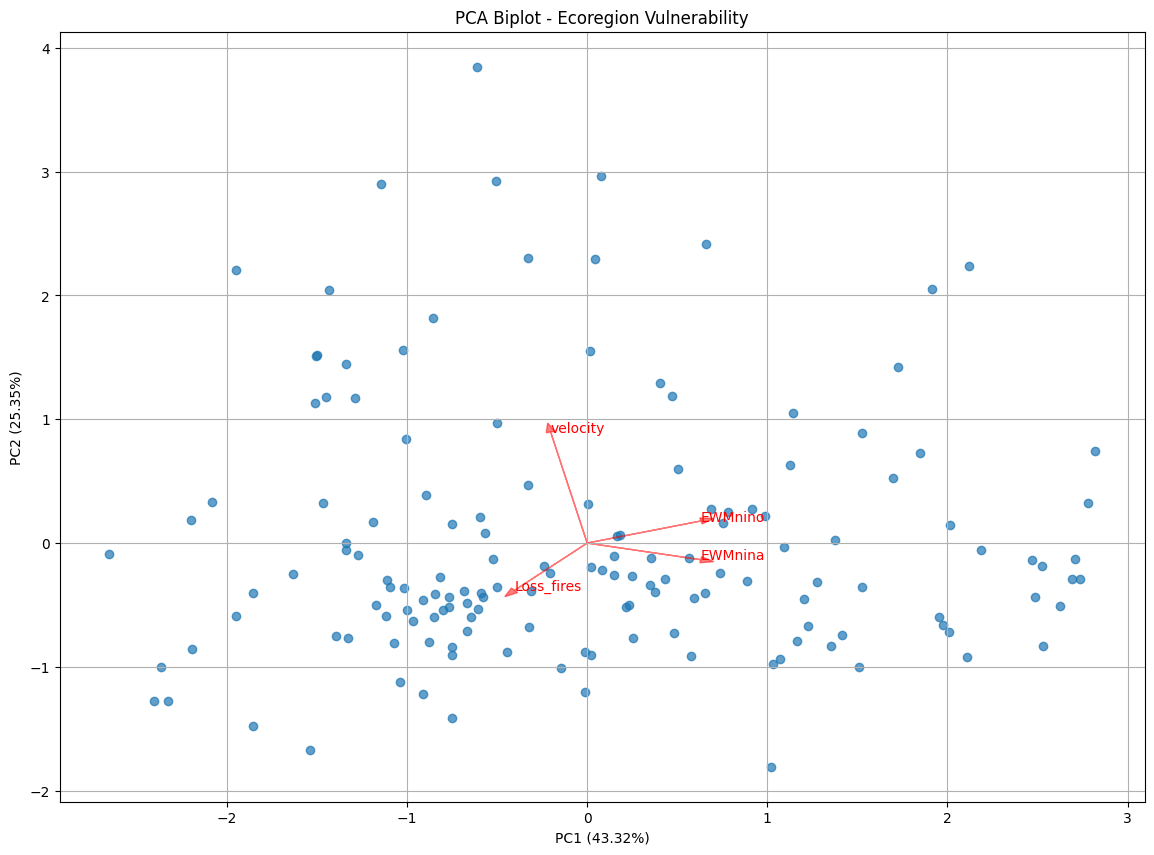

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select the columns for PCA
features = ["EWMnino", "EWMnina", "velocity", "Loss_fires"]
gdf_selected = ecoregions_exp[["ECO_NAME"] + features].dropna()  # Drop missing values

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(gdf_selected[features])

# Perform PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data)

# Convert to DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2", "PC3"])
pca_df["Ecoregion"] = gdf_selected["ECO_NAME"]

# Compute explained variance percentages
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage

# Plot PCA Biplot
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot of ecoregions
ax.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.7, label="Ecoregions")

# Annotate ecoregions with labels
# for i, txt in enumerate(pca_df["Ecoregion"]):
#     ax.annotate(txt, (pca_df["PC1"][i], pca_df["PC2"][i]), fontsize=8, alpha=0.7)

# Add PCA component vectors
components = pca.components_.T
for i, feature in enumerate(features):
    ax.arrow(0, 0, components[i, 0], components[i, 1], color="r", alpha=0.5, head_width=0.05)
    ax.text(components[i, 0], components[i, 1], feature, color="r", fontsize=10)

# Update axis labels with variance percentage
ax.set_xlabel(f"PC1 ({explained_variance[0]:.2f}%)")
ax.set_ylabel(f"PC2 ({explained_variance[1]:.2f}%)")
ax.set_title("PCA Biplot - Ecoregion Vulnerability")
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
ax.set_title("PCA Biplot - Ecoregion Vulnerability")
plt.grid()
plt.show()


          PC1       PC2       PC3                                    Ecoregion
0   -1.951615  2.205088 -0.000566                 Alto Paraná Atlantic forests
1   -0.012623 -1.202626  0.899089  Amazon-Orinoco-Southern Caribbean mangroves
2    1.912334  2.053304  0.634715              Apure-Villavicencio dry forests
3   -1.336582  0.003158 -1.063675                      Araucaria moist forests
4    0.754745  0.159190 -0.766645                  Araya and Paria xeric scrub
..        ...       ...       ...                                          ...
145 -0.751239  0.153330 -0.006345             South American Pacific mangroves
146 -2.654151 -0.091342  2.120001                                          NaN
147 -0.505784  2.925292  1.454138                       Southern Andean Yungas
148 -0.442676 -0.881252  0.386633        Southern Atlantic Brazilian mangroves
149  0.249051 -0.264063 -1.078881                                          NaN

[150 rows x 4 columns]


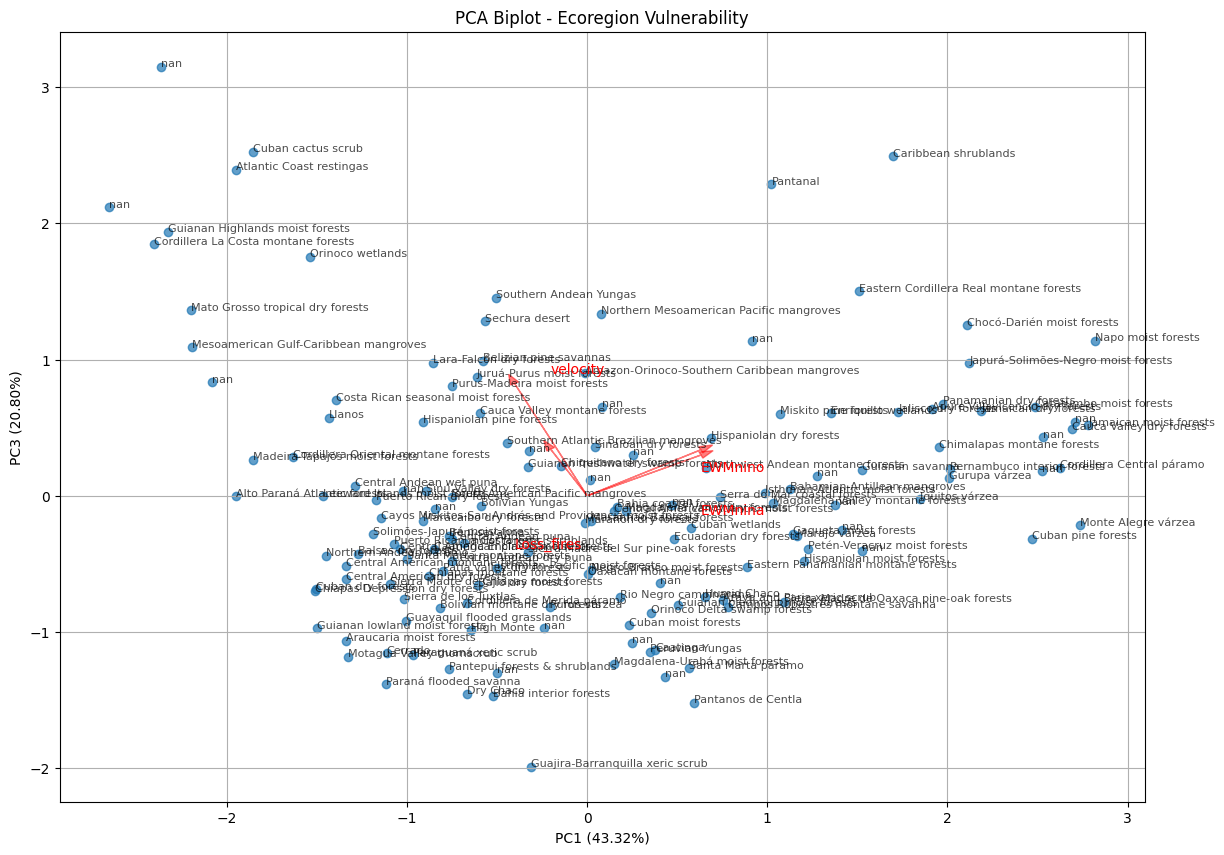

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select the columns for PCA
features = ["EWMnino", "EWMnina", "velocity", "Loss_fires"]
gdf_selected = ecoregions_exp[["ECO_NAME"] + features].dropna()  # Drop missing values

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(gdf_selected[features])

# Perform PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data)

# Convert to DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2", "PC3"])
pca_df["Ecoregion"] = gdf_selected["ECO_NAME"]
print(pca_df)

# Compute explained variance percentages
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage

# Plot PCA Biplot
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot of ecoregions
ax.scatter(pca_df["PC1"], pca_df["PC3"], alpha=0.7, label="Ecoregions")

# Annotate ecoregions with labels
for i, txt in enumerate(pca_df["Ecoregion"]):
    ax.annotate(txt, (pca_df["PC1"][i], pca_df["PC3"][i]), fontsize=8, alpha=0.7)

# Add PCA component vectors
components = pca.components_.T
for i, feature in enumerate(features):
    ax.arrow(0, 0, components[i, 0], components[i, 2], color="r", alpha=0.5, head_width=0.05)
    ax.text(components[i, 0], components[i, 1], feature, color="r", fontsize=10)

# Update axis labels with variance percentage
ax.set_xlabel(f"PC1 ({explained_variance[0]:.2f}%)")
ax.set_ylabel(f"PC3 ({explained_variance[2]:.2f}%)")
ax.set_title("PCA Biplot - Ecoregion Vulnerability")
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
ax.set_title("PCA Biplot - Ecoregion Vulnerability")
plt.grid()
plt.show()


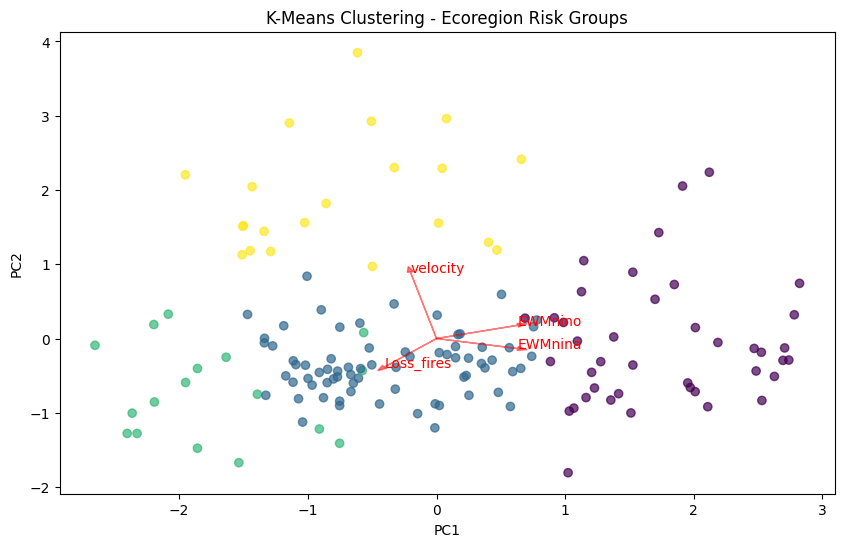

In [ ]:
from sklearn.cluster import KMeans

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
gdf_selected["Cluster"] = kmeans.fit_predict(scaled_data)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(pca_df["PC1"], pca_df["PC2"], c=gdf_selected["Cluster"], cmap="viridis", alpha=0.7)
# Add PCA component vectors
components = pca.components_.T
for i, feature in enumerate(features):
    ax.arrow(0, 0, components[i, 0], components[i, 1], color="r", alpha=0.5, head_width=0.05)
    ax.text(components[i, 0], components[i, 1], feature, color="r", fontsize=10)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("K-Means Clustering - Ecoregion Groups")
# ax.colorbar(label="Cluster")
plt.show()


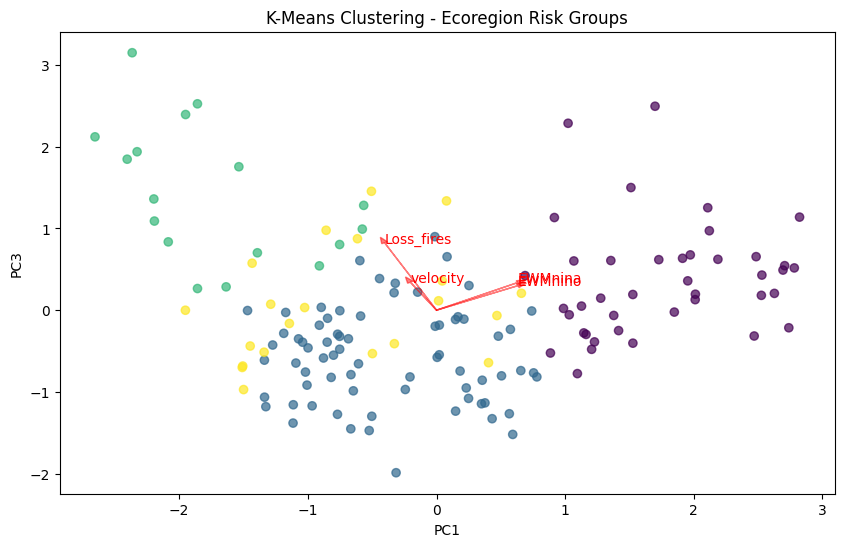

In [ ]:
from sklearn.cluster import KMeans

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
gdf_selected["Cluster"] = kmeans.fit_predict(scaled_data)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(pca_df["PC1"], pca_df["PC3"], c=gdf_selected["Cluster"], cmap="viridis", alpha=0.7)
# Add PCA component vectors
components = pca.components_.T
for i, feature in enumerate(features):
    ax.arrow(0, 0, components[i, 0], components[i, 2], color="r", alpha=0.5, head_width=0.05)
    ax.text(components[i, 0], components[i, 2], feature, color="r", fontsize=10)

ax.set_xlabel("PC1")
ax.set_ylabel("PC3")
ax.set_title("K-Means Clustering - Ecoregion Groups")
# ax.colorbar(label="Cluster")
plt.show()


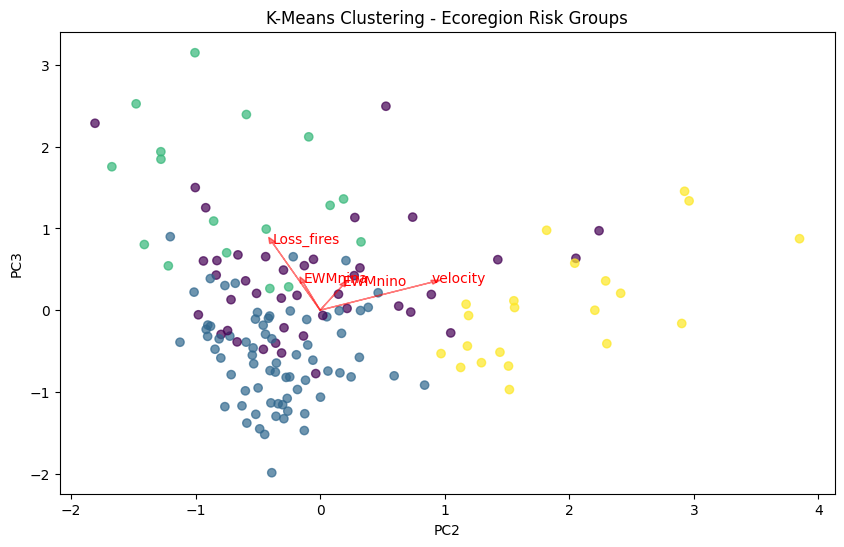

In [ ]:
from sklearn.cluster import KMeans

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
gdf_selected["Cluster"] = kmeans.fit_predict(scaled_data)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(pca_df["PC2"], pca_df["PC3"], c=gdf_selected["Cluster"], cmap="viridis", alpha=0.7)
# Add PCA component vectors
components = pca.components_.T
for i, feature in enumerate(features):
    ax.arrow(0, 0, components[i, 1], components[i, 2], color="r", alpha=0.5, head_width=0.05)
    ax.text(components[i, 1], components[i, 2], feature, color="r", fontsize=10)

ax.set_xlabel("PC2")
ax.set_ylabel("PC3")
# ax.set_title("PCA grouping")
# ax.colorbar(label="Cluster")
plt.show()


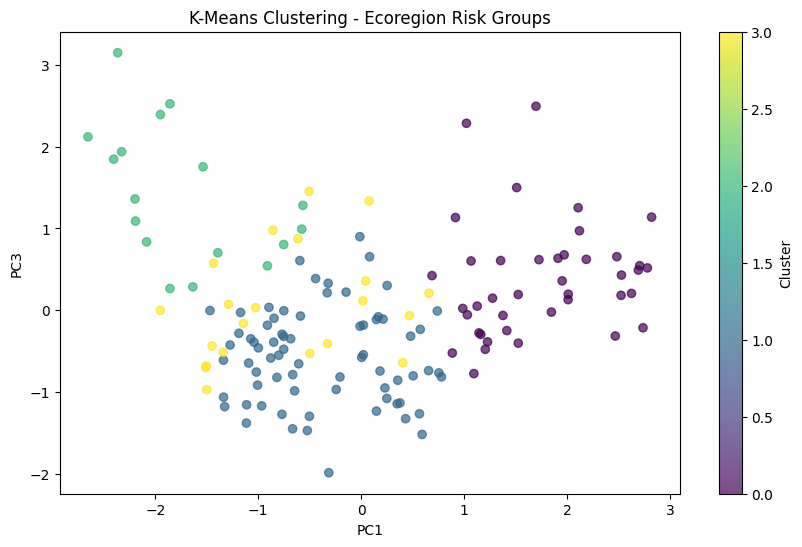

In [39]:
from sklearn.cluster import KMeans

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
gdf_selected["Cluster"] = kmeans.fit_predict(scaled_data)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(pca_df["PC1"], pca_df["PC3"], c=gdf_selected["Cluster"], cmap="viridis", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.title("K-Means Clustering - Ecoregion Risk Groups")
plt.colorbar(label="Cluster")
plt.show()


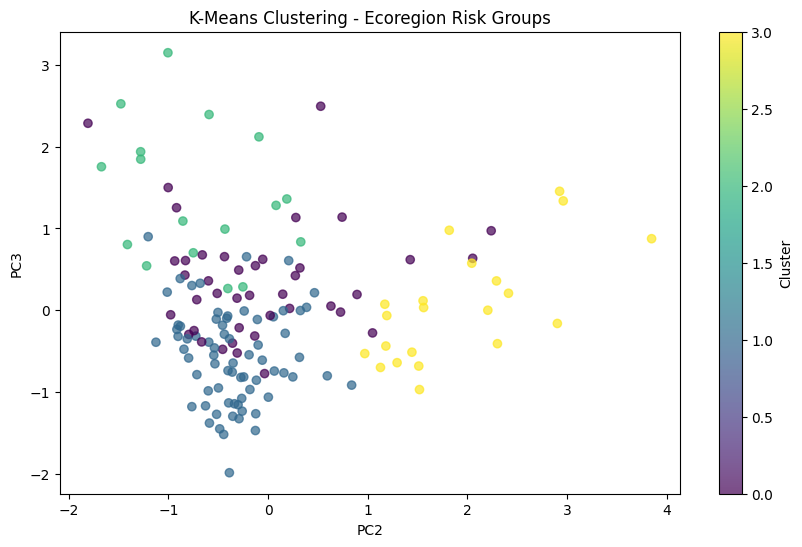

In [40]:
from sklearn.cluster import KMeans

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
gdf_selected["Cluster"] = kmeans.fit_predict(scaled_data)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(pca_df["PC2"], pca_df["PC3"], c=gdf_selected["Cluster"], cmap="viridis", alpha=0.7)
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.title("K-Means Clustering - Ecoregion Risk Groups")
plt.colorbar(label="Cluster")
plt.show()


/tmp/ipykernel_14796/829189927.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_clusters))
/tmp/ipykernel_14796/829189927.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(cluster_data[pc_x], cluster_data[pc_y],


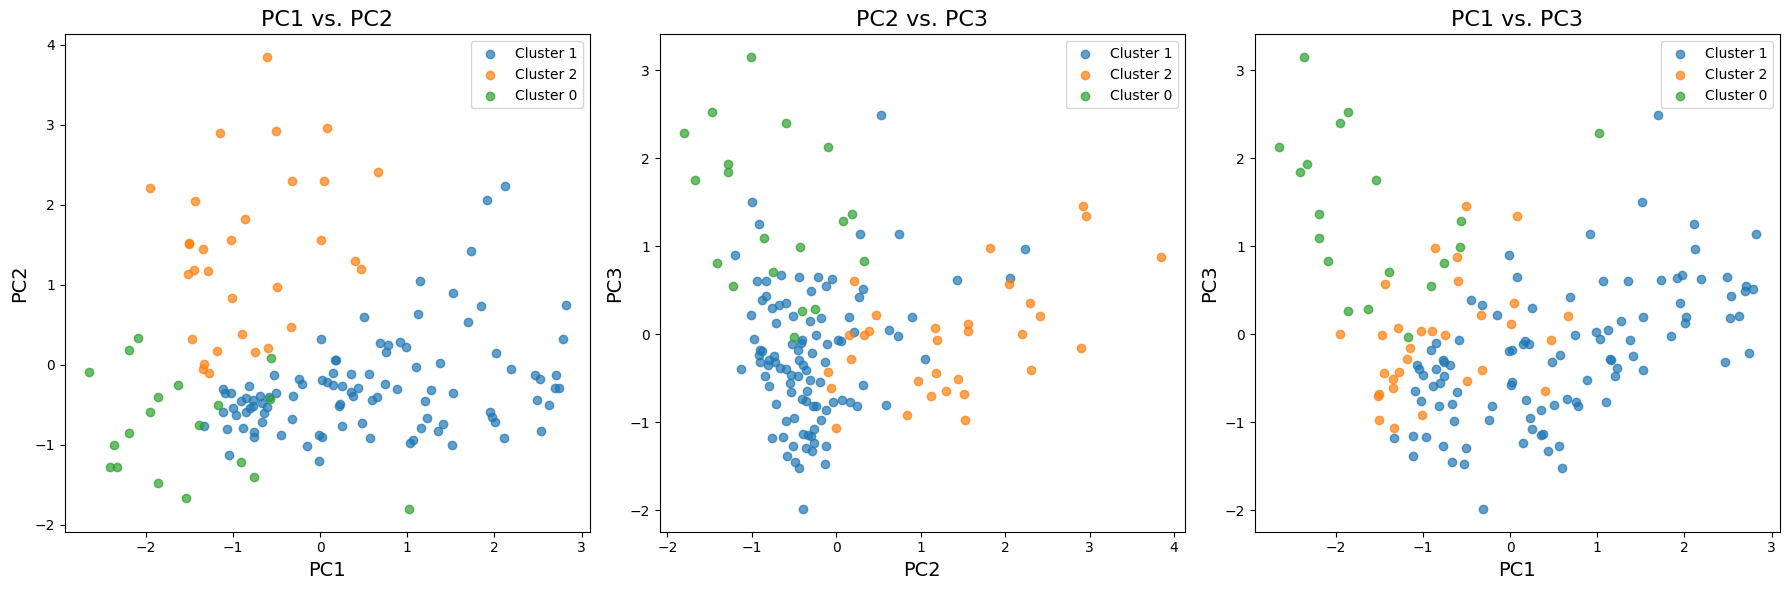

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_pca_clusters(csv_path):
    """
    Plot PCA clusters in individual 2D plots:
    - PC1 vs. PC2
    - PC2 vs. PC3
    - PC1 vs. PC3
    """

    # Load the PCA-transformed data with clusters
    pca_df = pd.read_csv(csv_path)

    # Define plot pairs
    plot_pairs = [("PC1", "PC2"), ("PC2", "PC3"), ("PC1", "PC3")]

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Define colors for clusters
    unique_clusters = pca_df["Cluster"].unique()
    colors = plt.cm.get_cmap("tab10", len(unique_clusters))

    # Loop through the PC pairs and create scatter plots
    for i, (pc_x, pc_y) in enumerate(plot_pairs):
        ax = axes[i]
        for cluster in unique_clusters:
            cluster_data = pca_df[pca_df["Cluster"] == cluster]
            ax.scatter(cluster_data[pc_x], cluster_data[pc_y], 
                       label=f"Cluster {cluster}", alpha=0.7, cmap=colors)

        # Set labels and title
        ax.set_xlabel(pc_x, fontsize=14)
        ax.set_ylabel(pc_y, fontsize=14)
        ax.set_title(f"{pc_x} vs. {pc_y}", fontsize=16)
        ax.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# Example usage
plot_pca_clusters("outputs/csv/pca_reduced_data_with_clusters.csv")


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

# Load PCA-transformed data
pca_df = pd.read_csv("outputs/csv/pca_reduced_data_with_clusters.csv")

# Define threshold for strong influence (75th percentile of absolute PC scores)
threshold_PC1 = np.percentile(abs(pca_df["PC1"]), 75)
threshold_PC2 = np.percentile(abs(pca_df["PC2"]), 75)
threshold_PC3 = np.percentile(abs(pca_df["PC3"]), 75)

# ✅ Create synthetic points with exaggerated effects
synthetic_points = pd.DataFrame({
    "ECO_ID": ["Synthetic_1", "Synthetic_2", "Synthetic_3", "Synthetic_4"],
    "PC1": [threshold_PC1 * 1.8, -threshold_PC1 * 1.8, threshold_PC1 * 1.5, -threshold_PC1 * 1.5],
    "PC2": [threshold_PC2 * 1.8, threshold_PC2 * 1.5, -threshold_PC2 * 1.8, -threshold_PC2 * 1.5],
    "PC3": [threshold_PC3 * 1.8, threshold_PC3 * 1.5, -threshold_PC3 * 1.8, -threshold_PC3 * 1.5],
    "Cluster": ["Synthetic", "Synthetic", "Synthetic", "Synthetic"]
})

# ✅ Append synthetic points to original PCA data
pca_with_synthetic = pd.concat([pca_df, synthetic_points], ignore_index=True)

# ✅ Create an interactive 3D scatter plot including synthetic points
fig = px.scatter_3d(
    pca_with_synthetic, 
    x="PC1", 
    y="PC2", 
    z="PC3", 
    color="Cluster",
    opacity=0.5,
    title="Ecoregions Strongly Affected by All Four Effects (with Synthetic Points)",
    hover_data={"ECO_ID": True}
)

# ✅ Highlight the synthetic points in **red**
fig.add_trace(px.scatter_3d(
    synthetic_points, 
    x="PC1", 
    y="PC2", 
    z="PC3", 
    color_discrete_sequence=["red"], 
    opacity=1.0, 
    hover_data={"ECO_ID": True}
).data[0])

# ✅ Show plot
fig.show()


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px

# Load PCA-transformed data and PCA loadings
pca_df = pd.read_csv("outputs/csv/pca_reduced_data_with_clusters.csv")
loadings_df = pd.read_csv("outputs/csv/pca_loadings.csv", index_col=0)  # Load PCA loadings

# Define thresholds for strong PC influence (e.g., 75th percentile)
threshold_PC1 = np.percentile(abs(pca_df["PC1"]), 75)
threshold_PC2 = np.percentile(abs(pca_df["PC2"]), 75)
threshold_PC3 = np.percentile(abs(pca_df["PC3"]), 75)

# Define threshold for PCA loadings to ensure variables significantly contribute
loading_threshold = 0.15  # Adjust this if too strict

# ✅ Apply filtering to select real ecoregions affected by ALL effects
filtered_df = pca_df[
    (abs(pca_df["PC1"]) >= threshold_PC1) &  
    (abs(pca_df["PC2"]) >= threshold_PC2) &  
    (abs(pca_df["PC3"]) >= threshold_PC3) &  
    (abs(loadings_df.loc["EWMnino", "PC1"]) > loading_threshold) &  
    (abs(loadings_df.loc["EWMnina", "PC2"]) > loading_threshold) &  
    (abs(loadings_df.loc["PrimaryLoss_Fires50%", "PC3"]) > loading_threshold) &  
    (abs(loadings_df.loc["primaryLoss_rate", "PC2"]) > loading_threshold)
]

# ✅ Create synthetic points with exaggerated effects
synthetic_points = pd.DataFrame({
    "ECO_ID": ["Synthetic_1", "Synthetic_2", "Synthetic_3", "Synthetic_4"],
    "PC1": [threshold_PC1 * 1.8, -threshold_PC1 * 1.8, threshold_PC1 * 1.5, -threshold_PC1 * 1.5],
    "PC2": [threshold_PC2 * 1.8, threshold_PC2 * 1.5, -threshold_PC2 * 1.8, -threshold_PC2 * 1.5],
    "PC3": [threshold_PC3 * 1.8, threshold_PC3 * 1.5, -threshold_PC3 * 1.8, -threshold_PC3 * 1.5],
    "Cluster": ["Synthetic", "Synthetic", "Synthetic", "Synthetic"]
})

# ✅ Append synthetic points to filtered real ecoregions
pca_with_synthetic = pd.concat([filtered_df, synthetic_points], ignore_index=True)

# ✅ Create a 3D scatter plot including both real and synthetic points
fig = px.scatter_3d(
    pca_df,  # Plot all points
    x="PC1", 
    y="PC2", 
    z="PC3", 
    color="Cluster",
    opacity=0.5,
    title="Ecoregions Strongly Affected by All Four Effects (with Synthetic Points)",
    hover_data={"ECO_ID": True}
)

# ✅ Highlight real filtered ecoregions in **blue**
fig.add_trace(px.scatter_3d(
    filtered_df, 
    x="PC1", 
    y="PC2", 
    z="PC3", 
    color_discrete_sequence=["blue"], 
    opacity=1.0, 
    hover_data={"ECO_ID": True}
).data[0])

# ✅ Highlight synthetic points in **red**
fig.add_trace(px.scatter_3d(
    synthetic_points, 
    x="PC1", 
    y="PC2", 
    z="PC3", 
    color_discrete_sequence=["red"], 
    opacity=1.0, 
    hover_data={"ECO_ID": True}
).data[0])

# ✅ Show plot
fig.show()


In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import ace_tools_open as tools  # For visualization

# Load PCA-transformed data
pca_df = pd.read_csv("outputs/csv/pca_reduced_data_with_clusters.csv")

# Standardize PC scores (z-scores)
pca_df["PC1_z"] = (pca_df["PC1"] - pca_df["PC1"].mean()) / pca_df["PC1"].std()
pca_df["PC2_z"] = (pca_df["PC2"] - pca_df["PC2"].mean()) / pca_df["PC2"].std()
pca_df["PC3_z"] = (pca_df["PC3"] - pca_df["PC3"].mean()) / pca_df["PC3"].std()

# Compute a Combined Score (sum of absolute z-scores)
pca_df["Combined_Score"] = abs(pca_df["PC1_z"]) + abs(pca_df["PC2_z"]) + abs(pca_df["PC3_z"])

# Set threshold at the 75th percentile (top 25% of highest scores)
threshold_combined = np.percentile(pca_df["Combined_Score"], 75)

# Filter ecoregions in the top 25% of total combined effects
filtered_df = pca_df[pca_df["Combined_Score"] >= threshold_combined]

# Display the filtered dataframe
tools.display_dataframe_to_user(name="Filtered Ecoregions with High Combined Effects", dataframe=filtered_df)

# Create a 3D scatter plot highlighting these points
fig = px.scatter_3d(
    pca_df, 
    x="PC1", 
    y="PC2", 
    z="PC3", 
    color="Cluster",
    opacity=0.5,
    title="Ecoregions Strongly Affected by All Three Effects",
    hover_data={"ECO_ID": True}
)

# Highlight the filtered points in red
fig.add_trace(px.scatter_3d(
    filtered_df, 
    x="PC1", 
    y="PC2", 
    z="PC3", 
    color_discrete_sequence=["red"], 
    opacity=1.0, 
    hover_data={"ECO_ID": True}
).data[0])

# Show plot
fig.show()


Filtered Ecoregions with High Combined Effects


In [1]:
print((41/179)*100)
print(22/179*100)
print(17/179*100)
print(70/179*100)

22.905027932960895
12.290502793296088
9.497206703910614
39.10614525139665
